In [19]:
!pip install qiskit
!pip install qiskit_ibm_runtime
!pip install matplotlib
!pip install networkx
!pip install qiskit_optimization
!pip install pylatexenc

  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136863 sha256=0359137a8b1a8270b38d30b31f3981d0c38e76be34f808acbbdec51e1bb4645c
  Stored in directory: /global/u2/g/gzquse/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


In [1]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler as RuntimeSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import CouplingMap, Layout
from qiskit.providers.fake_provider import GenericBackendV2


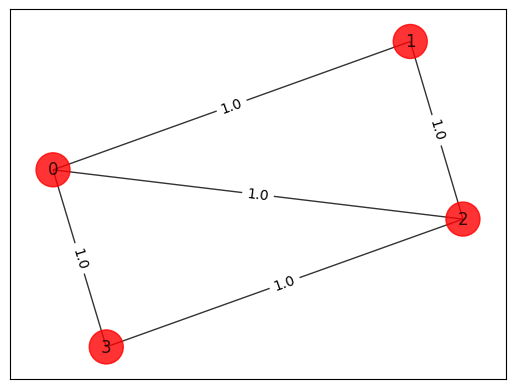

In [2]:
# Generating a graph of 4 nodes

n = 4  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

In [3]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


In [4]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 3*x_0 + 2*x_1
  + 3*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [5]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -2.5
Ising Hamiltonian:
SparsePauliOp(['IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZZII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


In [6]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

objective function value: 4.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0
status: SUCCESS


energy: -1.5
max-cut objective: -4.0
solution: [1. 0. 1. 0.]
solution objective: 4.0


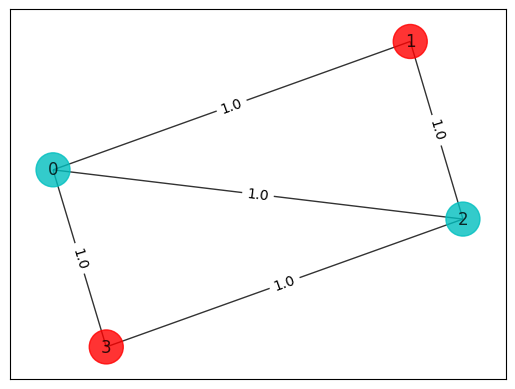

In [7]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

In [8]:
algorithm_globals.random_seed = 123
seed = 10598

/tmp/ipykernel_2067816/639890245.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)


energy: -1.4996861455587294
time: 1.9013152122497559
max-cut objective: -3.999686145558729
solution: [0 1 0 1]
solution objective: 4.0


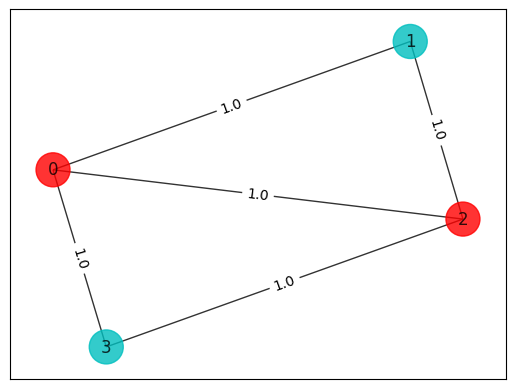

In [9]:
# construct SamplingVQE
optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

# run SamplingVQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

In [10]:
vqe.ansatz.draw()

»
   q_0: »
        »
   q_1: »
        »
   q_2: »
        »
   q_3: »
        »
meas: 4/»
        »
«        ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«   q_0: ┤0                                                                                                                                                 ├»
«        │                                                                                                                                                  │»
«   q_1: ┤1                                                                                                                                                 ├»
«        │  TwoLocal(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11],θ[12],θ[13],θ[14],θ[15],θ[16],θ[17],θ[18],θ[19],θ[20],θ[21],θ[22],θ[23]) │»
«   q_2: ┤2                                                                                                                                                 ├»
«        │                                                                                                                                                  │»
«   q_3: ┤3                                                                                                                                                 ├»
«        └──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘»
«meas: 4/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════»
«                                                                                                                                                            »
«         ░ ┌─┐         
«   q_0: ─░─┤M├─────────
«         ░ └╥┘┌─┐      
«   q_1: ─░──╫─┤M├──────
«         ░  ║ └╥┘┌─┐   
«   q_2: ─░──╫──╫─┤M├───
«         ░  ║  ║ └╥┘┌─┐
«   q_3: ─░──╫──╫──╫─┤M├
«         ░  ║  ║  ║ └╥┘
«meas: 4/════╩══╩══╩══╩═
«            0  1  2  3

In [11]:
service = QiskitRuntimeService(channel="ibm_quantum") # or your preferred channel
# backend = service.backend('ibm_brisbane')

In [12]:
from qiskit_ibm_runtime.fake_provider import FakeTorino
backend = FakeTorino()

In [13]:
circuit = vqe.ansatz

CZ gate count (after transpilation): 15


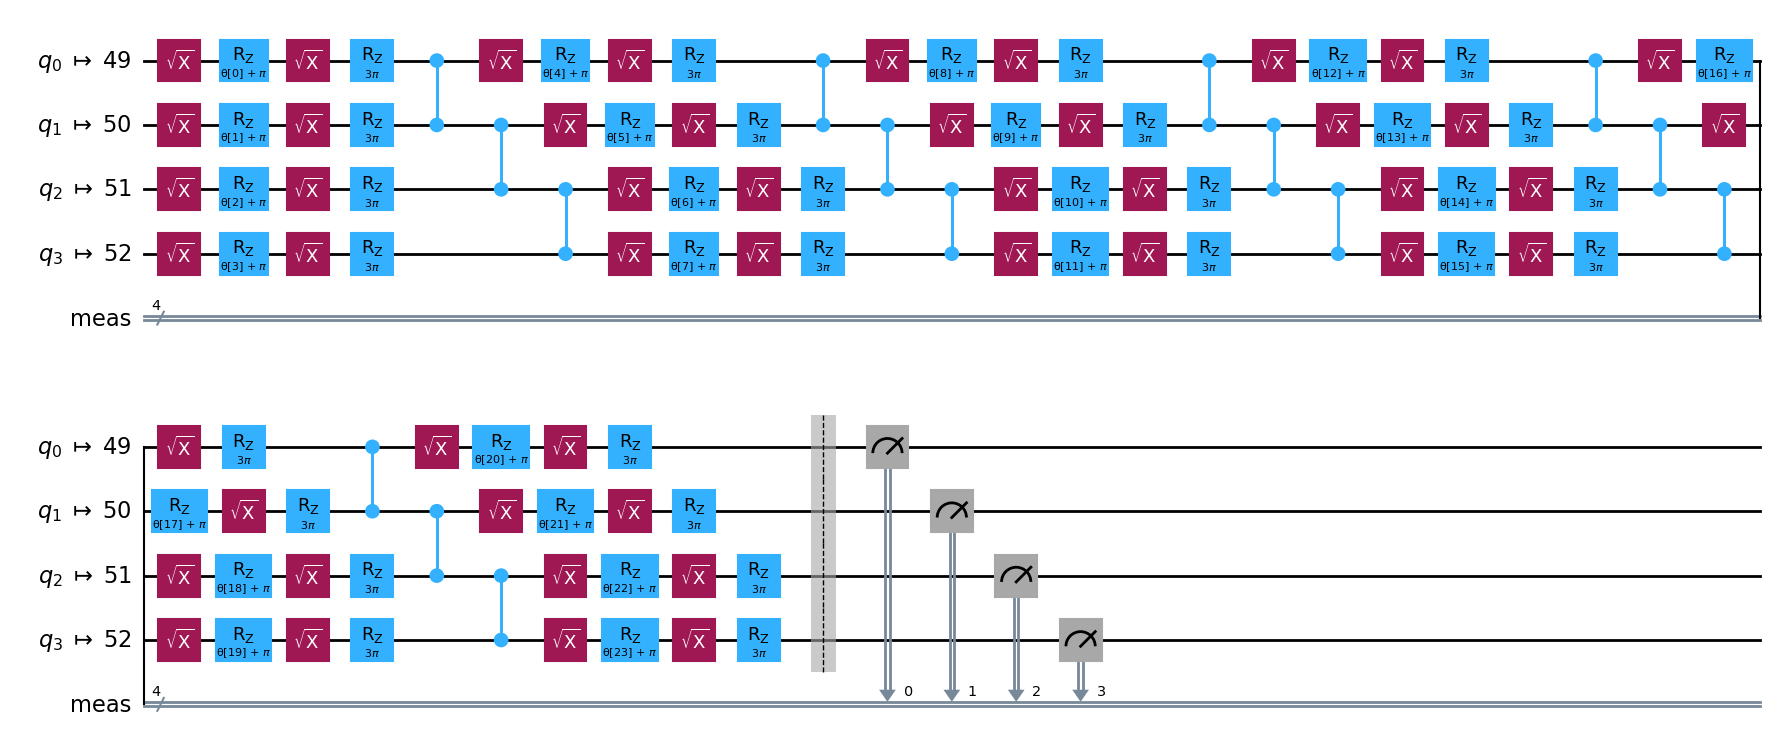

In [15]:
# Initialize IBM Provider
#IBMProvider.save_account(token='0e989b46ee0ef391f07a1624af87ee5c8edd6e1e866acb8cbf46958ab8d27e5fb13f4568535d58efeb8a1f126f61fc251d19c65d6d500b934c28882cdd0aea85')

# Get the backend (replace 'ibm_torino' with the correct backend name if needed)
coupling_map = backend.configuration().coupling_map

# Generate the optimization level 3 pass manager
# pm = generate_preset_pass_manager(3, backend)

# Transpile the circuit using the pass manager
transpiled_circuit = transpile(circuit, backend=backend)

# Count CZ gates in the transpiled circuit
cz_count = transpiled_circuit.count_ops().get('cz', 0)

# Update VQE ansatz and run
vqe._ansatz = transpiled_circuit
result = vqe.compute_minimum_eigenvalue(qubitOp)

# ... (Your existing code for printing and plotting results) ...

print("CZ gate count (after transpilation):", cz_count)

# Draw the transpiled circuit (optional)
transpiled_circuit.draw('mpl', idle_wires=False)